In [1]:
import cvxpy as cp # python 3.7 로 해야.... 하루종일 걸려서 발견...
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import pickle 

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


In [2]:
from labelling import XYGeneration

# Dataloading

## X loading 

In [3]:

def pd_setting(dataframe):
    dataframe.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
    dataframe['Date'] = dataframe.Date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d') )
    dataframe = dataframe.set_index(['Date'])

    return dataframe

In [4]:
price_df = pd_setting(pd.read_csv("./data/features/price_df.csv"))
mu_df = pd_setting(pd.read_csv("./data/features/mu_df.csv"))
sigma_df = pd_setting(pd.read_csv("./data/features/sigma_df.csv"))

In [5]:
feat_date = price_df.index
dff_col_name = list(price_df.columns)


## Y loading

In [6]:
dff = pd.read_csv("./data/df_XY.csv")
dff.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
dff['Date'] = dff.Date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d') )
dff = dff.set_index(['Date'])

dfy = dff.loc[feat_date]
# extracting Y columns
Y_col = [x for x in dfy.columns if x[-2:]=='_Y']
dfy = dfy[Y_col]

# XY Generation
- df_target : dfy
- df_intput : price_df, mu_df, sigma_df

## Scaling

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [8]:
dff_col_name = price_df.columns

In [9]:
dff.shape

(8184, 27)

In [10]:
price_df.shape

(7931, 27)

In [11]:
# price normalization 
# z_scaler = StandardScaler()
# z_scaler.fit(price_df)
# price_df_z = z_scaler.transform(price_df)
# price_df_z = pd.DataFrame(price_df_z, columns = dff_col_name, index = feat_date)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(price_df)
price_df_mm = min_max_scaler.transform(price_df)
price_df_mm = pd.DataFrame(price_df_mm, columns = dff_col_name, index = feat_date)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(mu_df)
mu_df_mm = min_max_scaler.transform(mu_df)
mu_df_mm = pd.DataFrame(mu_df_mm, columns = dff_col_name, index = feat_date)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(sigma_df)
sigma_df_mm = min_max_scaler.transform(sigma_df)
sigma_df_mm = pd.DataFrame(sigma_df_mm, columns = dff_col_name, index = feat_date)

# Dataset Generation & Labelling

In [12]:
in_past_seq = 120  
tr_past_seq = 252
rf = 0.02

In [13]:
# Loading generator
generator = XYGeneration(dfy, tr_past_seq, rf)

In [14]:
# Y labelling 
Y = generator.Y_generation()

In [15]:
Y[0].shape

(9,)

### X concatenation 

In [16]:
x_p, x_index = generator.X_generation(price_df_mm, in_past_seq)
x_m, _ = generator.X_generation(mu_df_mm, in_past_seq)
x_s, _ = generator.X_generation(sigma_df_mm, in_past_seq)

In [17]:
len(x_index)

353

In [18]:
X = []
for i in range(len(x_index)):
    x_p_arr = np.expand_dims(x_p[i], -1)
    x_m_arr = np.expand_dims(x_m[i], -1)
    x_s_arr = np.expand_dims(x_s[i], -1)
    
    X_arr = np.concatenate([x_p_arr, x_m_arr, x_s_arr], axis = -1)
    
    X.append(X_arr)
    

In [19]:
len(X)

353

In [20]:
len(Y)

353

In [21]:
Y[0].shape

(9,)

# DataLoader

In [22]:
from torch.utils.data import DataLoader
import torch

In [23]:
X_arr.shape

(120, 27, 3)

In [24]:
X[0].shape

(120, 27, 3)

In [25]:
num_samples = len(X)
num_train = round(len(X)*0.7)

num_val = round(num_train*0.2)
num_train = num_train - num_val
num_test = num_samples - num_train



num_nodes = X[0].shape[1]
feat_dim = X[0].shape[-1]




x_train, y_train = X[:num_train], Y[:num_train]
x_val, y_val = X[num_train : num_train+num_val], Y[num_train : num_train+num_val]
x_test , y_test = X[num_train+num_val : ], Y[num_train+num_val : ]





In [26]:
np.array(x_train).shape

(198, 120, 27, 3)

In [27]:
np.array(x_val).shape

(49, 120, 27, 3)

In [28]:
np.array(x_test).shape

(106, 120, 27, 3)

In [29]:
train_iter = ([(torch.from_numpy(x).float(),torch.from_numpy(y).float()) for x,y in zip(x_train, y_train)])
val_iter = ([(torch.from_numpy(x).float(),torch.from_numpy(y).float()) for x,y in zip(x_val, y_val)])
test_iter = ([(torch.from_numpy(x).float(),torch.from_numpy(y).float()) for x,y in zip(x_test, y_test)])


In [30]:
train_iter[-1][0].shape

torch.Size([120, 27, 3])

In [31]:
val_iter[-1][0].shape

torch.Size([120, 27, 3])

In [32]:
train_iter[-1][0] == val_iter[-1][0]

tensor([[[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        ...,

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [Fa

In [33]:

train_dataloader = DataLoader(train_iter, batch_size=12, shuffle=True, drop_last = True)
valid_dataloader = DataLoader(val_iter, batch_size=12, shuffle=True, drop_last = True)
test_dataloader = DataLoader(test_iter, batch_size=12, shuffle=True, drop_last = True)

In [34]:
valid_dataloader

# Model 

In [56]:
m = nn.Softmax(dim = 1)
input = torch.randn(2,3,1,1)
o = m(input)


In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys


class nconv(nn.Module):
    def __init__(self):
        super(nconv,self).__init__()

    def forward(self,x, A):
        x = torch.einsum('ncvl,vw->ncwl',(x,A))
        return x.contiguous()

class linear(nn.Module):
    def __init__(self,c_in,c_out):
        super(linear,self).__init__()
        self.mlp = torch.nn.Conv2d(c_in, c_out, kernel_size=(1, 1), padding=(0,0), stride=(1,1), bias=True) # 

    def forward(self,x):
        return self.mlp(x)

class gcn(nn.Module):
    def __init__(self,c_in,c_out,dropout,support_len=3,order=2):
        super(gcn,self).__init__()
        self.nconv = nconv()
        c_in = (order*support_len+1)*c_in
        self.mlp = linear(c_in,c_out)
        self.dropout = dropout
        self.order = order

    def forward(self,x,support):
        out = [x]
        for a in support:
            x1 = self.nconv(x,a)
            out.append(x1)
            for k in range(2, self.order + 1):
#                 print ("K")
#                 print (k)
                
                
#                 print (x1.shape)
#                 print (a.shape)
                
                x2 = self.nconv(x1,a)
                out.append(x2)
                x1 = x2
        
        h = torch.cat(out,dim=1)
        h = self.mlp(h)
        h = F.dropout(h, self.dropout, training=self.training)
        return h
    
###############################################################################################################################################
###############################################################################################################################################
class gwnet(nn.Module):
    def __init__(self, device, num_nodes, dropout=0.3, supports=None, gcn_bool=True, addaptadj=True, aptinit=None, 
                 in_dim=3, out_dim=1, out_dim2 = 9, residual_channels=32,dilation_channels=32,skip_channels=256,
                 end_channels=512,kernel_size=2,blocks=4,layers=2):
        super(gwnet, self).__init__()
        self.dropout = dropout
        self.blocks = blocks
        self.layers = layers
        self.gcn_bool = gcn_bool
        self.addaptadj = addaptadj

        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.bn = nn.ModuleList()
        self.gconv = nn.ModuleList()

        self.start_conv = nn.Conv2d(in_channels=in_dim,
                                    out_channels=residual_channels,
                                    kernel_size=(1,1))
        self.supports = supports

        receptive_field = 1

        self.supports_len = 0
        if supports is not None:
            self.supports_len += len(supports)

        if gcn_bool and addaptadj:
            if aptinit is None:
                if supports is None:
                    self.supports = []
                self.nodevec1 = nn.Parameter(torch.randn(num_nodes, 10).to(device), requires_grad=True).to(device)
                self.nodevec2 = nn.Parameter(torch.randn(10, num_nodes).to(device), requires_grad=True).to(device)
                self.supports_len +=1
            else:
                if supports is None:
                    self.supports = []
                m, p, n = torch.svd(aptinit)
                initemb1 = torch.mm(m[:, :10], torch.diag(p[:10] ** 0.5))
                initemb2 = torch.mm(torch.diag(p[:10] ** 0.5), n[:, :10].t())
                self.nodevec1 = nn.Parameter(initemb1, requires_grad=True).to(device)
                self.nodevec2 = nn.Parameter(initemb2, requires_grad=True).to(device)
                self.supports_len += 1




        for b in range(blocks):
            additional_scope = kernel_size - 1
            new_dilation = 1
            for i in range(layers):
                # dilated convolutions
                self.filter_convs.append(nn.Conv2d(in_channels=residual_channels,
                                                   out_channels=dilation_channels,
                                                   kernel_size=(1,kernel_size),dilation=new_dilation))

                self.gate_convs.append(nn.Conv1d(in_channels=residual_channels,
                                                 out_channels=dilation_channels,
                                                 kernel_size=(1, kernel_size), dilation=new_dilation))

                # 1x1 convolution for residual connection
                self.residual_convs.append(nn.Conv1d(in_channels=dilation_channels,
                                                     out_channels=residual_channels,
                                                     kernel_size=(1, 1)))

                # 1x1 convolution for skip connection
                self.skip_convs.append(nn.Conv1d(in_channels=dilation_channels,
                                                 out_channels=skip_channels,
                                                 kernel_size=(1, 1)))
                self.bn.append(nn.BatchNorm2d(residual_channels))
                new_dilation *=2
                
                
#                 print ('dilation: ', new_dilation)
                
                
                receptive_field += additional_scope
                additional_scope *= 2
                if self.gcn_bool:
                    self.gconv.append(gcn(dilation_channels,residual_channels,dropout,support_len=self.supports_len))



        self.end_conv_1 = nn.Conv2d(in_channels=skip_channels,
                                  out_channels=end_channels,
                                  kernel_size=(1,1),
                                  bias=True)

        self.end_conv_2 = nn.Conv2d(in_channels=end_channels,
                                    out_channels=out_dim,
                                    kernel_size=(1,1),
                                    bias=True)
        
        self.end_conv_3 = nn.Conv2d(in_channels = num_nodes,
                                   out_channels = out_dim2, 
                                   kernel_size = (1,1), 
                                   bias = True)
        
        self.soft_max = nn.Softmax(dim = 1)
        
        self.receptive_field = receptive_field



    def forward(self, input):
        in_len = input.size(3)
        if in_len<self.receptive_field:
            x = nn.functional.pad(input,(self.receptive_field-in_len,0,0,0))
        else:
            x = input
        x = self.start_conv(x)
        skip = 0

        # calculate the current adaptive adj matrix once per iteration
        new_supports = None
        if self.gcn_bool and self.addaptadj and self.supports is not None:
            adp = F.softmax(F.relu(torch.mm(self.nodevec1, self.nodevec2)), dim=1)
            new_supports = self.supports + [adp]

        # WaveNet layers
        for i in range(self.blocks * self.layers):
#             print ('layers: ', self.blocks * self.layers)

            #            |----------------------------------------|     *residual*
            #            |                                        |
            #            |    |-- conv -- tanh --|                |
            # -> dilate -|----|                  * ----|-- 1x1 -- + -->	*input*
            #                 |-- conv -- sigm --|     |
            #                                         1x1
            #                                          |
            # ---------------------------------------> + ------------->	*skip*

            #(dilation, init_dilation) = self.dilations[i]

            #residual = dilation_func(x, dilation, init_dilation, i)
            residual = x
            # dilated convolution
            filter = self.filter_convs[i](residual)
            filter = torch.tanh(filter)
            gate = self.gate_convs[i](residual)
            gate = torch.sigmoid(gate)
            x = filter * gate

            # parametrized skip connection

            s = x
            s = self.skip_convs[i](s)
            try:
                skip = skip[:, :, :,  -s.size(3):]
            except:
                skip = 0
            skip = s + skip


            if self.gcn_bool and self.supports is not None:
                if self.addaptadj:
                    x = self.gconv[i](x, new_supports)
                else:
                    x = self.gconv[i](x,self.supports)
            else:
                x = self.residual_convs[i](x)

            x = x + residual[:, :, :, -x.size(3):]


            x = self.bn[i](x)

        x = F.relu(skip)
        x = F.relu(self.end_conv_1(x))
        x = self.end_conv_2(x) # [batch, dim, num_nodes, seq]
        # [12,1,27,1]
        
        
        x = x.transpose(2,1) # [12,27,1,1] [batch, num node, 1, 1]
        
        x = self.end_conv_3(x).transpose(3,1) 
        # [12,27,1,1] --> [12,9,1,1] --> [12,1,1,9] 
        
        x = self.soft_max(x) 
        
        return x

In [59]:
device = torch.device("cuda:1")
num_nodes = 27
dropout = 0.3
learning_rate = 0.001
wdecay = 0.0001

gcn_bool = True
addaptadj=True
aptinit=None
in_dim = 3
out_dim = 1
out_dim2 = 9
nhid = 32

kernel_size = 20

residual_channels=nhid 
dilation_channels=nhid
skip_channels=nhid * 8
end_channels=nhid * 16

num_block = 4
num_layer = 2

In [60]:
# model 
model = gwnet(device,num_nodes,dropout,supports=None,gcn_bool=gcn_bool,addaptadj=addaptadj,aptinit=aptinit,in_dim=in_dim,out_dim=out_dim, out_dim2=out_dim2,residual_channels=nhid,dilation_channels=nhid,skip_channels=nhid * 8,end_channels=nhid*16,kernel_size=20,blocks=num_block,layers=num_layer)
model.to(device) # model loading

criterion = torch.nn.L1Loss() # MAE 
criterion2 = torch.nn.KLDivLoss() # cross En

# criterion = torch.nn.L1Loss() # MAE 

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = wdecay)

In [61]:
loss = torch.nn.KLDivLoss()

out = torch.randn(12,9)
pred = torch.randn(12,1,9)

# loss(out,pred)

# Training

In [63]:

num_epochs = 100

loss_train = []
loss_valid = []

for epoch in range(1, num_epochs+1):
    model.train()

    epoch_train_loss = [] # loss average for one epoch
    epoch_valid_loss = []
##### training 
    for data in train_dataloader:
        optimizer.zero_grad()

        train_X, train_Y = data
        train_X = train_X.transpose(3,1)
        train_X = nn.functional.pad(train_X,(kernel_size-1,0,0,0))

        train_X = torch.Tensor(train_X).to(device)
        train_Y = torch.Tensor(train_Y).to(device)
        train_Y = train_Y.unsqueeze(1)
#         print ('X : ', train_X.size())
#         print ('Y : ', train_Y.size())
        train_out = model(train_X) #  [12,1,1,9] --> [12,1,9]
#         print ('out : ', train_out.size())
        train_out = train_out.squeeze()
        train_out = train_out.unsqueeze(1)
#         print('out: ',train_out.size())

#         loss = criterion(train_out,train_Y)
        loss = criterion2(train_out,train_Y)
        
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss.append(loss.item())

    loss_train.append(np.mean(epoch_train_loss))
    
##### validation 
    for data in valid_dataloader:
        valid_X, valid_Y = data
        valid_X = valid_X.transpose(3,1)
        valid_X = nn.functional.pad(valid_X, (kernel_size-1,0,0,0))
        
        valid_X = torch.Tensor(valid_X).to(device)
        valid_Y = torch.Tensor(valid_Y).to(device)
        valid_Y = valid_Y.unsqueeze(1)
        
        valid_out = model(valid_X)
        valid_out = valid_out.squeeze()
        valid_out = valid_out.unsqueeze(1)
        
#         loss = criterion(valid_out, valid_Y)
        loss = criterion2(valid_out, valid_Y)
        
        epoch_valid_loss.append(loss.item())
    loss_valid.append(np.mean(epoch_valid_loss))
        
    
    if epoch%50 == 0:
        print ("Epoch {}| tarin loss : {}, valid loss : {}".format(epoch,np.mean(epoch_train_loss), np.mean(epoch_valid_loss)))

Epoch 50| tarin loss : -0.29407477378845215, valid loss : -0.29407477378845215
Epoch 100| tarin loss : -0.29407477378845215, valid loss : -0.29407477378845215


In [64]:
i = 6
print (valid_out[i][0][1])
print (valid_Y[i][0][1])

tensor(1., device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.2500, device='cuda:1')


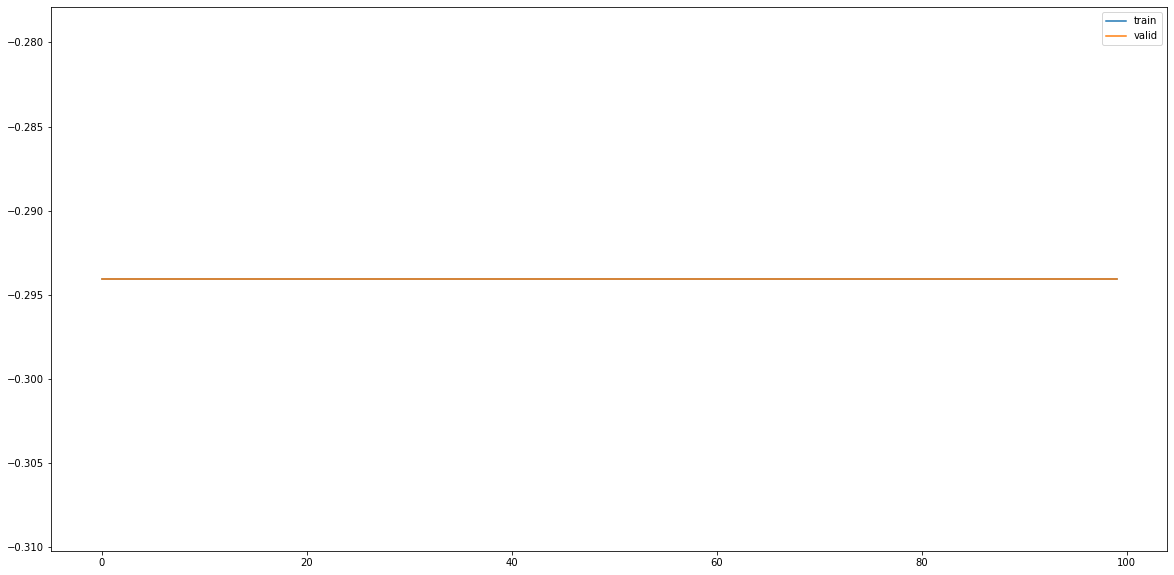

In [65]:
plt.figure(figsize = (20,10))
plt.plot(loss_train, label = 'train')
plt.plot(loss_valid, label = 'valid')
plt.legend()